## Spatial FHN model

In [1]:
import numpy as np 
import scipy as sp
# import tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt

# import sparse matrices
from scipy.sparse import csr_matrix

import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)



In [10]:
def FHN(t, y, return_nullclines=False):
    print(t,end='\r')
    u = y[:N]
    v = y[N:]
    du = a*u*(u-b)*(1-u) + G.dot(u) - v
    dv = e*(u-v)
    return np.append(du,dv)

In [11]:
T = 500
plot_n = 1000
N_x = 40
N_y = 40
N = N_x*N_y
y0 = np.zeros(2*N)
y0[N//2] = 0.7
e = 1e-2 
a, b = (3, 0.2)

In [151]:
G = np.zeros((N,N))
cells = np.arange(0,N,1)
G[cells,cells] = -4
G[cells,(cells+1)%N] = 1
G[cells,(cells-1)%N] = 1
G[cells,(cells+N_x)%N] = 1
G[cells,(cells-N_x)%N] = 1
G*=0.05

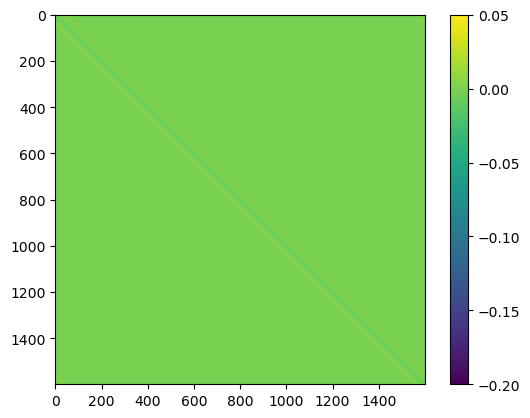

In [152]:
plt.imshow(G)
plt.colorbar()

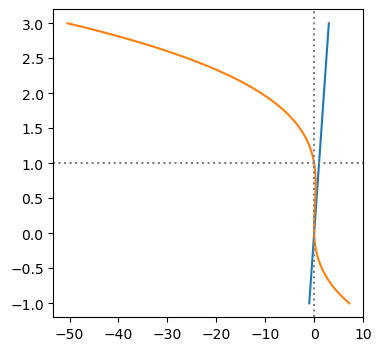

In [153]:
u_array = np.linspace(-1,3,100)
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(u_array,u_array)
e = 1e-3
a, b = (3, 0.2)
ax.plot(a*u_array*(u_array-b)*(1-u_array), u_array)
ax.axvline(0, c='grey', ls=':')
ax.axhline(1, c='grey', ls=':')

In [ ]:
out = sp.integrate.solve_ivp(FHN, (0, T), y0, t_eval=np.linspace(0, T, plot_n), method='BDF')

In [ ]:
plt.plot(out['t'],out['y']
         [N//2,:].T)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
im = ax.imshow(out['y'][:N, 20].reshape(N_x,N_y))
plt.colorbar(im)

Idea: use a lattice and the graph laplacian to achieve diffusion

In [34]:
import networkx as nx

# As I am not very sure what is best to do I'll leave a function to create the lattice
#both with periodic and open boundary conditions
def lattice_graph(m, periodic=False):
   
    if periodic:
        
        Graph = nx.grid_2d_graph(m, m, periodic=True)
    else:
        
        Graph = nx.grid_2d_graph(m, m)

    # Relabel nodes from (i, j) to a single index in range(m*n)
    mapping = {(i, j): i * m + j for i in range(m) for j in range(m)}
    Graph = nx.relabel_nodes(Graph, mapping)
    
    for u, v in Graph.edges():
        Graph[u][v]['weight'] = 20
    return Graph

Lattice=lattice_graph(N_x, periodic=True)
L = nx.laplacian_matrix(Lattice, weight='weight') #this is a scipy sparse array


In [47]:
T = 1000
plot_n = 1000
N_x = 40
N_y = 40
N = N_x*N_y
y0 = np.zeros(2*N)
y0[N//2] = 0.7
e = 1e-2 
a, b = (3, 0.2)

In [48]:
#the FHN equations would become
def FHN_graph(t, y, return_nullclines=False):
    print(t,end='\r')
    u = y[:N]
    v = y[N:]
    du = a*u*(u-b)*(1-u) - L.dot(u) - v
    dv = e*(u-v)
    return np.append(du,dv)

In [49]:
out = sp.integrate.solve_ivp(FHN_graph, (0, T), y0, t_eval=np.linspace(0, T, plot_n), method='BDF')

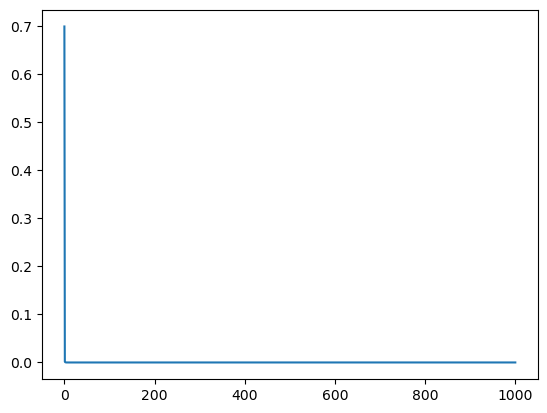

In [50]:
plt.plot(out['t'],out['y']
         [N//2,:].T)

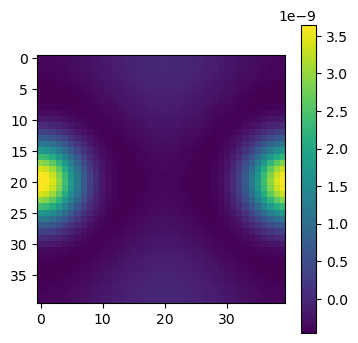

In [53]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
im = ax.imshow(out['y'][:N, 900].reshape(N_x,N_y))
plt.colorbar(im)

I guess this is quite cool cause we see the wave and although it does not invade the whole system it still goes around a bit and actually the action potential of the first neuron is gone when the wave propagates and goes back


## Brain

In [ ]:
#random network implementation
import random

def lattice_graph_random(m, n):
    
    G = nx.grid_2d_graph(m,n)
    
    
    mapping = {(i, j): i * n + j for i in range(m) for j in range(n)}
    G = nx.relabel_nodes(G, mapping)
    

    for (u, v) in G.edges():
        G[u][v]['weight'] = random.uniform(0, 1)#this might need to be adjusted

    return G

#or if we want a ER graph
def random_graph(N, p):
    
    G = nx.erdos_renyi_graph(N, p)
    

    for (u, v) in G.edges():
        G[u][v]['weight'] = random.uniform(0, 1)#this might need to be adjusted

    return G
Network=lattice_graph_random(N_x,N_x)
L = nx.laplacian_matrix(Network, weight='weight') 
# I have not tried to implement a globally connected graph with random weights